# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

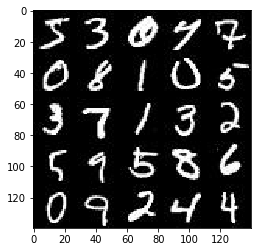

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

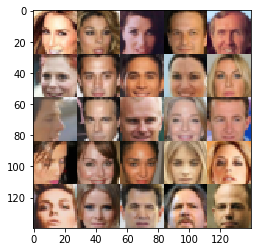

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #--------------------------
    # Real input images placeholder with rank 4 using image_width, image_height, and image_channels.
 
    input_real = tf.placeholder(tf.float32, shape=(None,image_width, image_height,image_channels), name='input_real')
    
    # Z input placeholder with rank 2 using z_dim.
    z_in = tf.placeholder(tf.float32, shape=(None,z_dim), name='input_z')
    
    # Learning rate placeholder with rank 0.
    lr_rate = tf.placeholder(tf.float32)

    return input_real, z_in, lr_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Ref: DCGAN Lab and Lectures
    #-----------------------------
    
    alpha=0.12
    keep_prob = 0.95
    
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2,224 , 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        
        #  7x7x224
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Ref: DCGAN Lab and Lectures
    #-----------------------------
    
    reuse= not is_train
    alpha=0.12
    keep_prob = 0.95 # suggested in https://github.com/soumith/ganhacks
    
    #z = (z-128.0)/128 #normalize images [-1,1]
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*224)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 224))
        x1 = tf.layers.batch_normalization(x1, training= is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 7x7x112 now
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training= is_train)
        x2 = tf.maximum(alpha * x2, x2) #implementing weak RELU
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x112 now
        
        x3 = tf.layers.conv2d_transpose(x2, 56, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 28x28x56 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xoutput now
        
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #smoothing real labels by 0.1
    # it prevents discriminator from being too strong and to generalize in a better way
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    # Thanks to the suggestions in the forum
    #https://discussions.udacity.com/t/cannot-run-mnist-with-error-you-must-feed-a-value-for-placeholder-tensor-input-real-with-dtype-float/248841/5 
    #___________________________________________________________
    # if I included the tf.GraphKeys.Update, then I will recieve the following error
    # You must feed a value for placeholder tensor 'input_real' with dtype float
    # The issue has been addressed in the above links and that's why I am commenting it
    #----------------------------------------------------------------------------------
   
    #with tf.control_dependencies(update_):
    #d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    #g_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)


    #Thanks for the following discussion and the answer provided by: aj85
    #https://discussions.udacity.com/t/project-5-net-not-training/246936/9
    
    update_ = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in update_ if var.name.startswith('generator')]
    d_update_ops = [var for var in update_ if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)


    return d_train, g_train
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]

    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    #example_z = np.random.normal(0, 1, [n_images, z_dim])
    

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #Thanks to the post:
    #https://discussions.udacity.com/t/list-index-out-of-range-on-last-epoch-for-mnist/247664/4
    #tf.reset_default_graph()
    
    input_real, input_z, lr_rate = model_inputs(data_shape[1],
                                                data_shape[2],
                                                data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real,
                                input_z,
                                data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=25
    show_every=100 
    n_images = 25
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #------------------
                steps += 1
                batch_images *= 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #batch_z = np.random.normal(0, 1, [batch_size, z_dim])

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    

                if steps % show_every == 0:
                    
                    _ = show_generator_output(sess, n_images, input_z, 
                                              data_shape[3], data_image_mode)
                    

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3609... Generator Loss: 0.0272
Epoch 1/2... Discriminator Loss: 1.8907... Generator Loss: 0.3155
Epoch 1/2... Discriminator Loss: 2.0532... Generator Loss: 0.3090
Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 0.6603


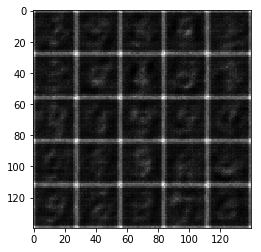

Epoch 1/2... Discriminator Loss: 1.7564... Generator Loss: 0.3261
Epoch 1/2... Discriminator Loss: 1.6163... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.8314


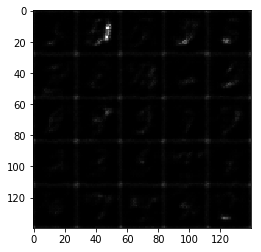

Epoch 1/2... Discriminator Loss: 1.6438... Generator Loss: 0.3579
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.5173


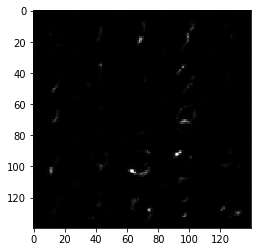

Epoch 1/2... Discriminator Loss: 1.7726... Generator Loss: 0.3832
Epoch 1/2... Discriminator Loss: 1.8599... Generator Loss: 0.3410
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.5367


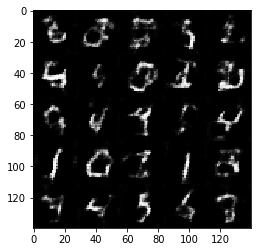

Epoch 1/2... Discriminator Loss: 1.7179... Generator Loss: 0.3980
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.8271
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.6034


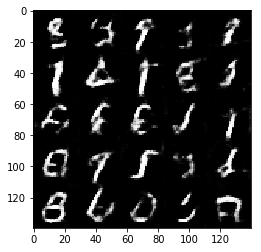

Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.6205... Generator Loss: 0.5825
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.7269


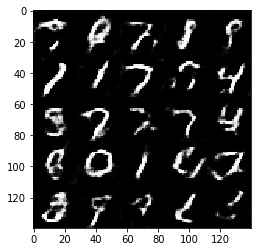

Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.6299... Generator Loss: 0.3608
Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.4310


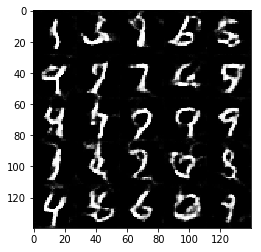

Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 1.2093
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 1.2188
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 0.8993


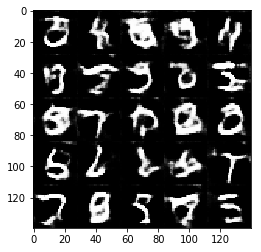

Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.9592
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 1.0460
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 0.8207


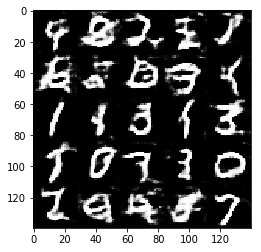

Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 1.2893
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.8051
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.2360


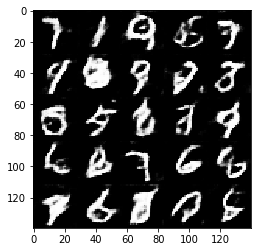

Epoch 1/2... Discriminator Loss: 1.5263... Generator Loss: 0.4034
Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 1.0783
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.6766
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.7373


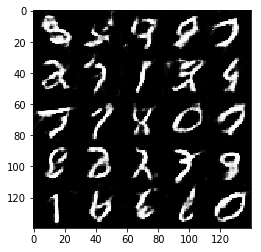

Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 2.1624
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 1.0195
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 1.3657
Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 1.3890


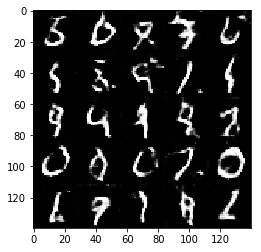

Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 1.3973
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 1.1806


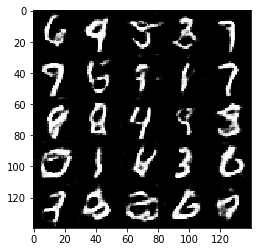

Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 1.9692
Epoch 1/2... Discriminator Loss: 0.9079... Generator Loss: 1.8764


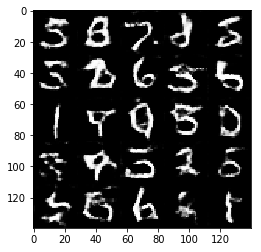

Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 1.7850
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 0.7067... Generator Loss: 1.8004


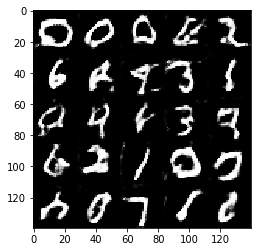

Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 1.8498
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.8833
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 1.1629


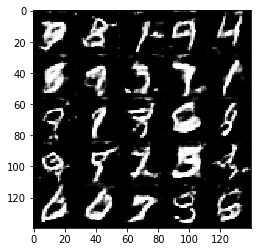

Epoch 1/2... Discriminator Loss: 1.3216... Generator Loss: 0.6278
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.5844
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 0.7297
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.1737


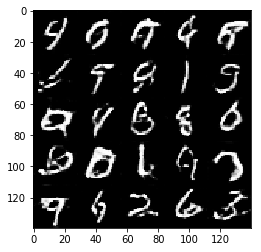

Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 1.5673
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 1.7326
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 1.8681
Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 0.9473


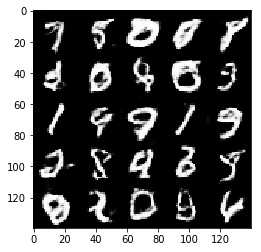

Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 1.3944
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 2.0814
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 1.5219


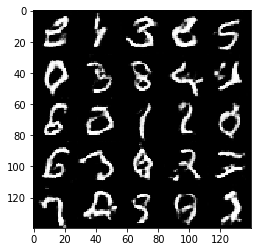

Epoch 1/2... Discriminator Loss: 0.6711... Generator Loss: 1.7656
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.4004
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 1.1605


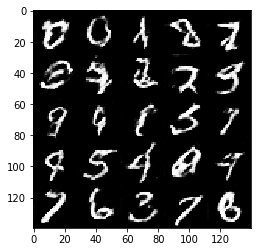

Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 1.1646
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 1.7600
Epoch 1/2... Discriminator Loss: 0.6770... Generator Loss: 1.8301
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.9771


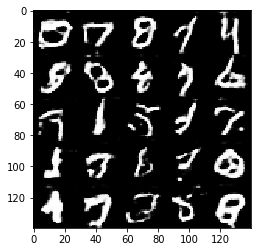

Epoch 1/2... Discriminator Loss: 1.8591... Generator Loss: 0.3742
Epoch 1/2... Discriminator Loss: 1.3958... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 0.6770
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 2.0895


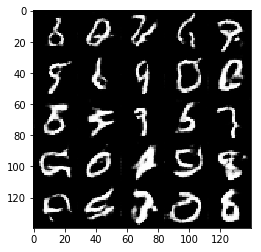

Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 2.2052
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.8914
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 0.7396


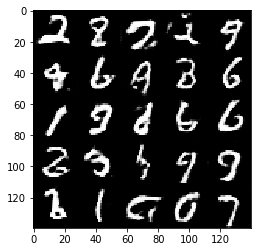

Epoch 1/2... Discriminator Loss: 1.6790... Generator Loss: 0.5739
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 1.5113
Epoch 1/2... Discriminator Loss: 0.7502... Generator Loss: 1.2438
Epoch 1/2... Discriminator Loss: 0.5930... Generator Loss: 1.8149


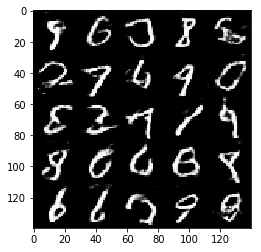

Epoch 1/2... Discriminator Loss: 0.7426... Generator Loss: 1.2311
Epoch 1/2... Discriminator Loss: 0.9281... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 0.9747


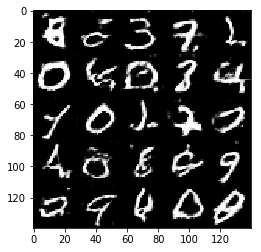

Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.3968
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.4418
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 2.1337... Generator Loss: 0.2024


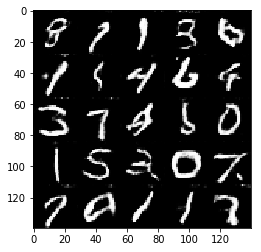

Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 1.1795
Epoch 1/2... Discriminator Loss: 0.5426... Generator Loss: 1.9442
Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 2.9598


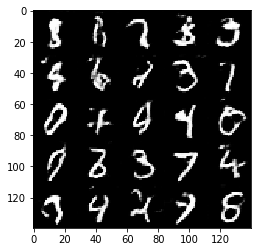

Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 0.7484... Generator Loss: 1.3562
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 1.8189


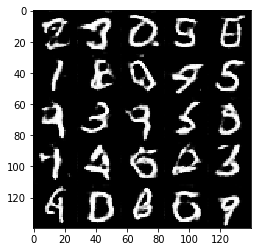

Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.6278
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.4859
Epoch 1/2... Discriminator Loss: 0.7985... Generator Loss: 1.0040


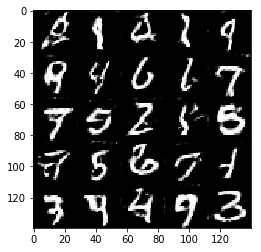

Epoch 1/2... Discriminator Loss: 0.5379... Generator Loss: 1.9918
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 1.0429
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.0086
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.0119


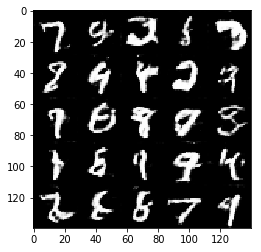

Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 1.8531
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 0.8318... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 1.0081


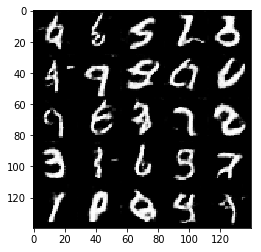

Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 2.5474
Epoch 1/2... Discriminator Loss: 0.8481... Generator Loss: 1.1723
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 1.6597
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 1.0393


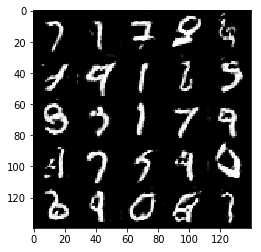

Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 1.4890
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 0.6152... Generator Loss: 1.4391
Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.6670


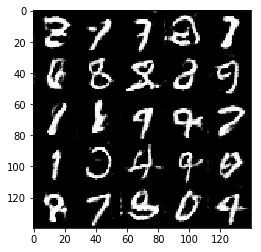

Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 1.0540
Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 1.2243
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 1.0416
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.7904


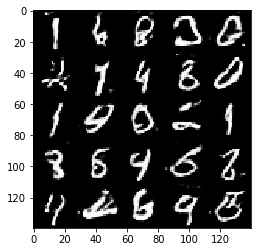

Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 2.0534
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.4140
Epoch 1/2... Discriminator Loss: 0.3967... Generator Loss: 3.1956
Epoch 1/2... Discriminator Loss: 0.7289... Generator Loss: 2.1052


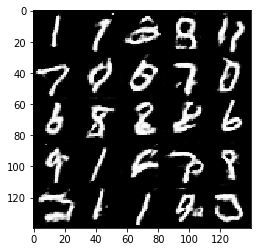

Epoch 1/2... Discriminator Loss: 2.1315... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.4840
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 1.4221
Epoch 1/2... Discriminator Loss: 0.6716... Generator Loss: 1.4160


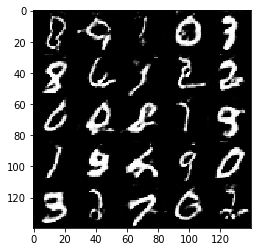

Epoch 1/2... Discriminator Loss: 1.1336... Generator Loss: 2.2525
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 2.3145
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 1.6096
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 2.0372


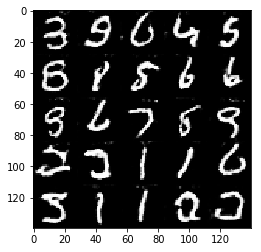

Epoch 1/2... Discriminator Loss: 0.6684... Generator Loss: 1.6466
Epoch 1/2... Discriminator Loss: 0.7057... Generator Loss: 1.5394
Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 1.8620
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 1.1289


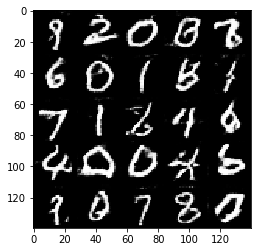

Epoch 1/2... Discriminator Loss: 0.7665... Generator Loss: 1.3423
Epoch 1/2... Discriminator Loss: 0.5486... Generator Loss: 1.7063
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.2258


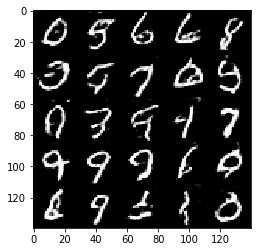

Epoch 1/2... Discriminator Loss: 1.5135... Generator Loss: 4.7384
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 1.6275
Epoch 1/2... Discriminator Loss: 0.9220... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 0.8166... Generator Loss: 1.3529


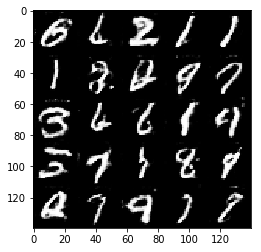

Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 1.6045
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 0.5063... Generator Loss: 1.8631
Epoch 1/2... Discriminator Loss: 0.5420... Generator Loss: 1.9338


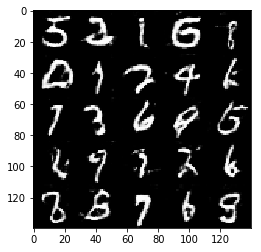

Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.4997
Epoch 1/2... Discriminator Loss: 0.4889... Generator Loss: 2.2366
Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.3969


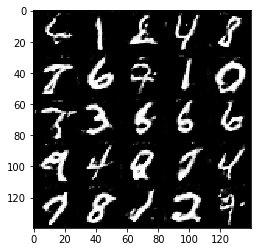

Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.3850
Epoch 1/2... Discriminator Loss: 0.5904... Generator Loss: 1.8268
Epoch 2/2... Discriminator Loss: 0.6111... Generator Loss: 2.3232


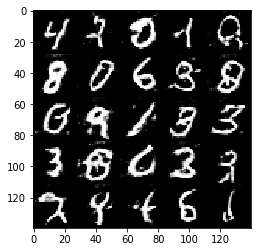

Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 1.7046
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.7474
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.0654


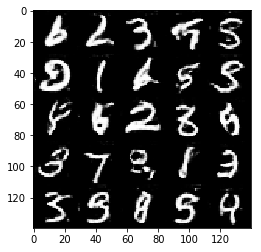

Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 1.7233
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 3.4991
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.2668


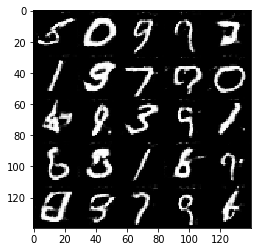

Epoch 2/2... Discriminator Loss: 0.6373... Generator Loss: 1.7917
Epoch 2/2... Discriminator Loss: 0.7412... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 1.7982... Generator Loss: 0.4571
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 2.4559


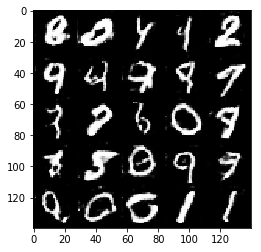

Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 1.3202
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.6910
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.5138
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.5328


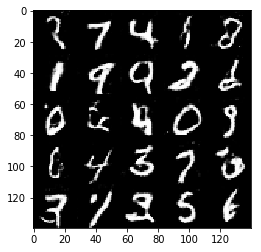

Epoch 2/2... Discriminator Loss: 0.5594... Generator Loss: 2.1998
Epoch 2/2... Discriminator Loss: 0.4874... Generator Loss: 2.2058
Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 2.3126
Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 1.4607


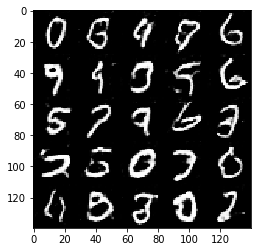

Epoch 2/2... Discriminator Loss: 0.5841... Generator Loss: 2.3201
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 1.4108
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.7999


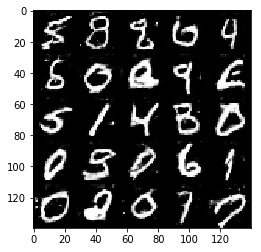

Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 2.0146
Epoch 2/2... Discriminator Loss: 0.5974... Generator Loss: 1.9620
Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 0.5119
Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.7511


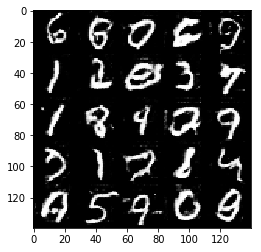

Epoch 2/2... Discriminator Loss: 0.9702... Generator Loss: 0.8852
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 0.9951
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.2822
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 1.4873


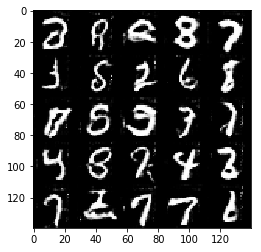

Epoch 2/2... Discriminator Loss: 0.5156... Generator Loss: 2.6108
Epoch 2/2... Discriminator Loss: 0.5044... Generator Loss: 1.5315
Epoch 2/2... Discriminator Loss: 0.5385... Generator Loss: 2.4044
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 1.7469


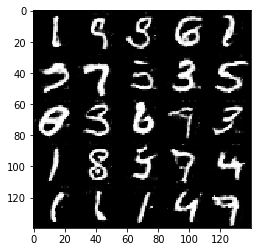

Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 2.6847
Epoch 2/2... Discriminator Loss: 0.4985... Generator Loss: 1.9732
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.1551
Epoch 2/2... Discriminator Loss: 0.4630... Generator Loss: 2.1353


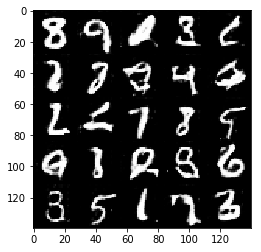

Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 1.4446
Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 2.9953
Epoch 2/2... Discriminator Loss: 0.4715... Generator Loss: 1.9157
Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 1.6484


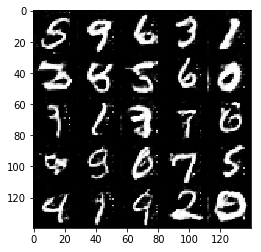

Epoch 2/2... Discriminator Loss: 0.4912... Generator Loss: 2.2298
Epoch 2/2... Discriminator Loss: 0.5416... Generator Loss: 2.1914
Epoch 2/2... Discriminator Loss: 0.6347... Generator Loss: 1.8356
Epoch 2/2... Discriminator Loss: 0.6557... Generator Loss: 1.8258


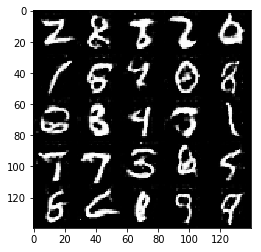

Epoch 2/2... Discriminator Loss: 0.4658... Generator Loss: 2.7693
Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 2.8154
Epoch 2/2... Discriminator Loss: 0.5252... Generator Loss: 2.6504
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.4336


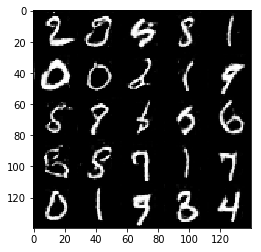

Epoch 2/2... Discriminator Loss: 0.5452... Generator Loss: 2.2811
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 1.3846
Epoch 2/2... Discriminator Loss: 0.6049... Generator Loss: 2.2673
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 2.6372


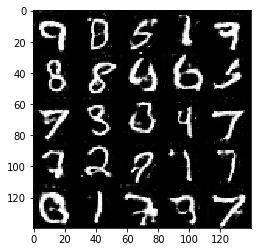

Epoch 2/2... Discriminator Loss: 0.5694... Generator Loss: 2.2352
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 1.9995
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 1.4667
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 2.2821


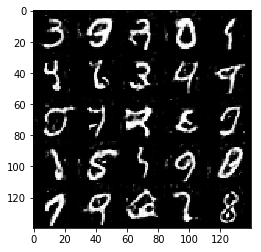

Epoch 2/2... Discriminator Loss: 0.5233... Generator Loss: 2.1498
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 4.1095
Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.6069
Epoch 2/2... Discriminator Loss: 0.5062... Generator Loss: 2.0183


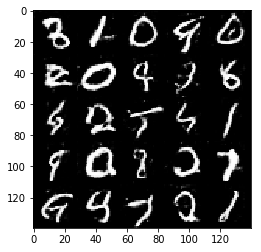

Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 1.6777
Epoch 2/2... Discriminator Loss: 0.6199... Generator Loss: 1.8779
Epoch 2/2... Discriminator Loss: 0.4865... Generator Loss: 2.3481
Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 1.7305


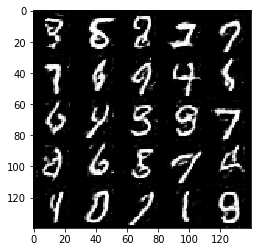

Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 2.3816
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.7886
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 0.8462
Epoch 2/2... Discriminator Loss: 0.6485... Generator Loss: 1.8372


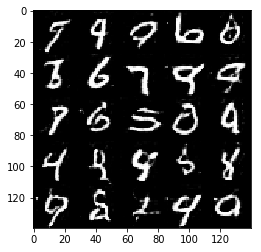

Epoch 2/2... Discriminator Loss: 0.4848... Generator Loss: 2.6601
Epoch 2/2... Discriminator Loss: 0.6616... Generator Loss: 2.1234
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 1.8294
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 1.9533


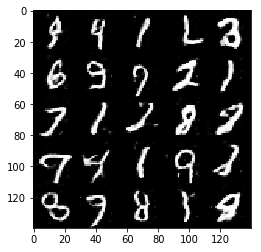

Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 2.3511
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.0853
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.7206


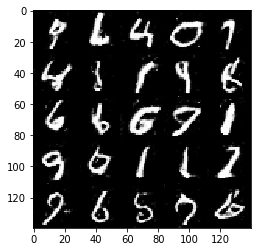

Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 2.5173
Epoch 2/2... Discriminator Loss: 0.5996... Generator Loss: 1.7948
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 2.6749


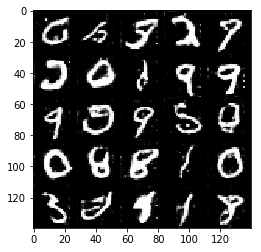

Epoch 2/2... Discriminator Loss: 0.6085... Generator Loss: 1.6160
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.8033
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 2.6189
Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 1.3543


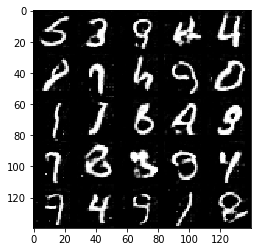

Epoch 2/2... Discriminator Loss: 0.5065... Generator Loss: 2.6658
Epoch 2/2... Discriminator Loss: 0.4704... Generator Loss: 2.6340
Epoch 2/2... Discriminator Loss: 0.5728... Generator Loss: 1.5569
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 1.6361


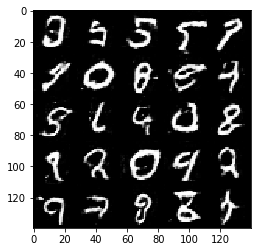

Epoch 2/2... Discriminator Loss: 0.8436... Generator Loss: 1.2399
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.9939
Epoch 2/2... Discriminator Loss: 0.4197... Generator Loss: 2.6668
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 3.0614


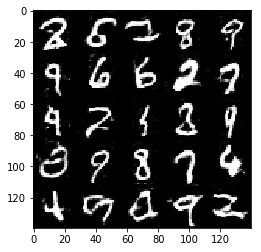

Epoch 2/2... Discriminator Loss: 0.6612... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 2.0011
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 3.0765
Epoch 2/2... Discriminator Loss: 0.5921... Generator Loss: 2.2194


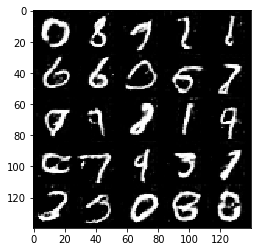

Epoch 2/2... Discriminator Loss: 0.7765... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 2.4349
Epoch 2/2... Discriminator Loss: 0.9255... Generator Loss: 2.2221
Epoch 2/2... Discriminator Loss: 0.4328... Generator Loss: 2.4355


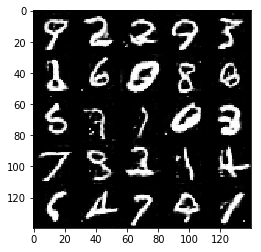

Epoch 2/2... Discriminator Loss: 0.6057... Generator Loss: 1.9486
Epoch 2/2... Discriminator Loss: 0.6323... Generator Loss: 2.0387
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.6756
Epoch 2/2... Discriminator Loss: 0.4366... Generator Loss: 2.5076


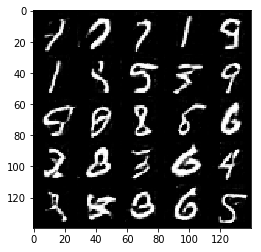

Epoch 2/2... Discriminator Loss: 0.5457... Generator Loss: 1.7109
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.3857
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 2.4681
Epoch 2/2... Discriminator Loss: 0.7179... Generator Loss: 1.8526


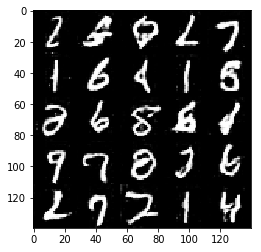

Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.1019
Epoch 2/2... Discriminator Loss: 1.0354... Generator Loss: 0.7128
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.0938
Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 1.0007


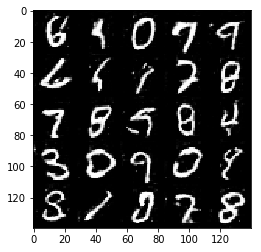

Epoch 2/2... Discriminator Loss: 0.6358... Generator Loss: 1.5735
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.6898
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.8466
Epoch 2/2... Discriminator Loss: 0.5106... Generator Loss: 2.2977


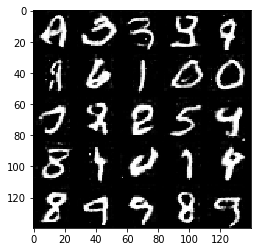

Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 3.0622
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.3395
Epoch 2/2... Discriminator Loss: 0.5874... Generator Loss: 1.7997
Epoch 2/2... Discriminator Loss: 0.4703... Generator Loss: 2.0988


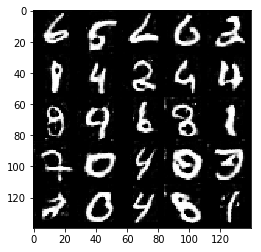

Epoch 2/2... Discriminator Loss: 0.4749... Generator Loss: 2.8813
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.6002
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 1.1761


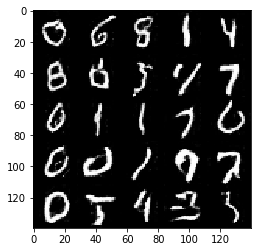

Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 2.0538
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 1.4057
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.4988
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.8897


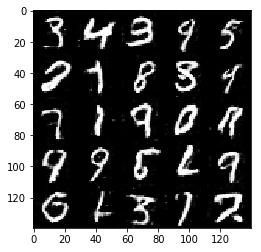

Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 0.6099... Generator Loss: 1.6174
Epoch 2/2... Discriminator Loss: 0.6058... Generator Loss: 1.7612
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 1.4986


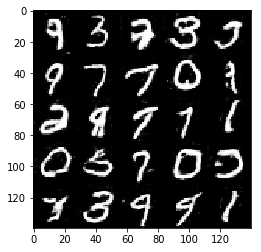

Epoch 2/2... Discriminator Loss: 0.4939... Generator Loss: 2.1671
Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 2.0095
Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 2.5246
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 1.5479


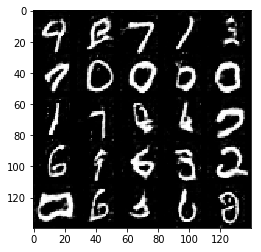

Epoch 2/2... Discriminator Loss: 0.5534... Generator Loss: 2.4236
Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 2.4136
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 1.3734
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.7701


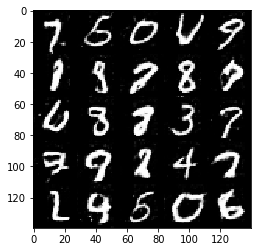

Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.7957
Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 3.4070
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 2.6177
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 2.6849


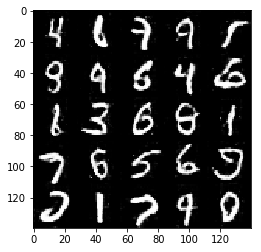

Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 1.5472
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 2.2683
Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 1.5741
Epoch 2/2... Discriminator Loss: 0.5440... Generator Loss: 1.5713


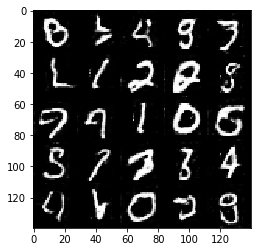

Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 2.3753
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 0.6760... Generator Loss: 2.8048
Epoch 2/2... Discriminator Loss: 0.6115... Generator Loss: 2.8674


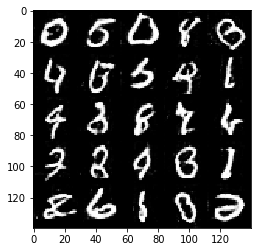

Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 1.4206
Epoch 2/2... Discriminator Loss: 0.5597... Generator Loss: 2.6199
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.8082
Epoch 2/2... Discriminator Loss: 0.5337... Generator Loss: 1.6034


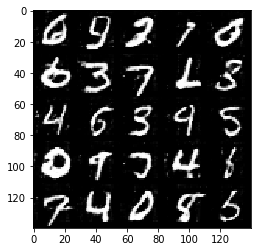

Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 1.4570
Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 2.8943
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.7199
Epoch 2/2... Discriminator Loss: 0.4196... Generator Loss: 3.3433


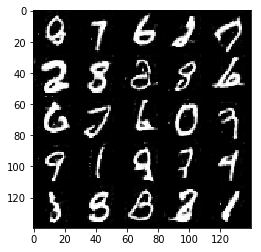

Epoch 2/2... Discriminator Loss: 0.4723... Generator Loss: 2.3434
Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 1.2796
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 2.0660
Epoch 2/2... Discriminator Loss: 0.6285... Generator Loss: 1.8975


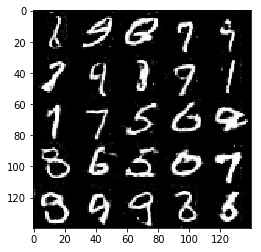

Epoch 2/2... Discriminator Loss: 0.4825... Generator Loss: 2.7307
Epoch 2/2... Discriminator Loss: 0.4565... Generator Loss: 2.0575


In [12]:
batch_size = 14
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.7713
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 3.9174
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 3.5016


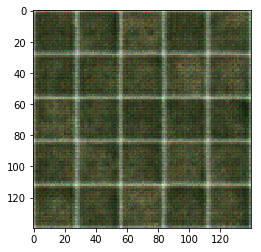

Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 2.5309
Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 2.6388
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 2.5051
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 3.8196


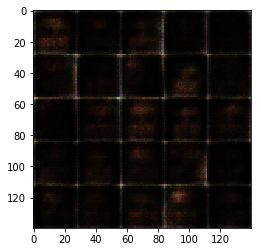

Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 3.2056
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.2524
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 2.7161
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 2.0485


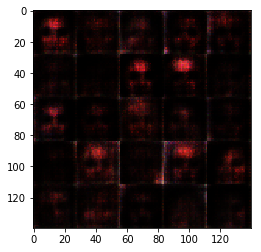

Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 2.0021
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 2.8263
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 3.2386


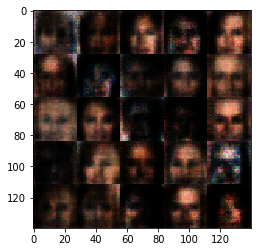

Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 2.8158
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 2.4954


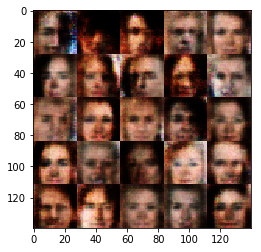

Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.3757
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 1.6270


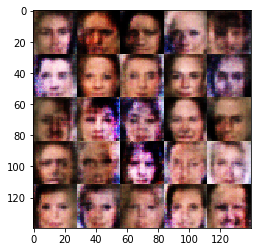

Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.4721


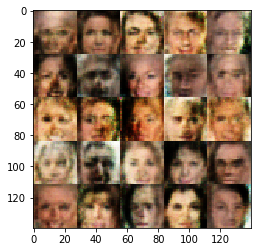

Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 2.5592
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 2.1652


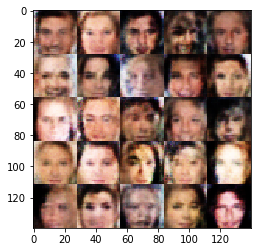

Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.4014


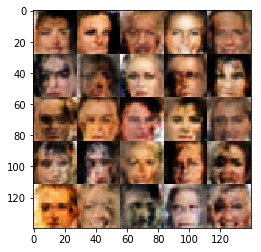

Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.2277


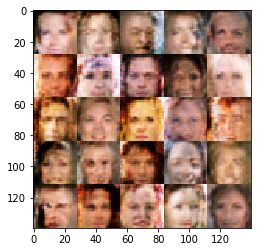

Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.8593
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.3662
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.3287


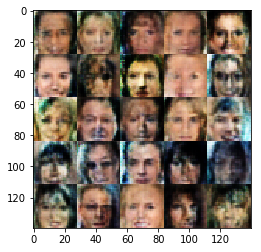

Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.0036


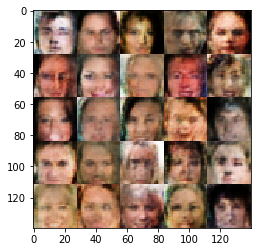

Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.6975


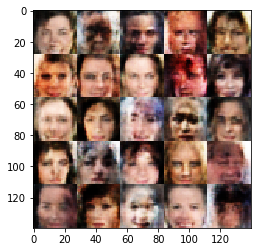

Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.0818


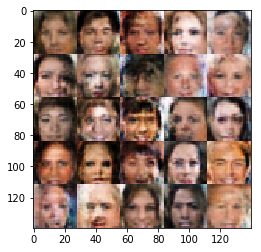

Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.2760


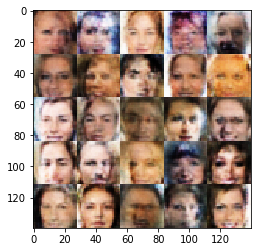

Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.9907
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.3153


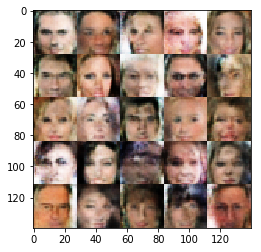

Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.3346
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.8568
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9146


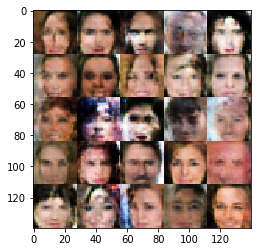

Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.9737


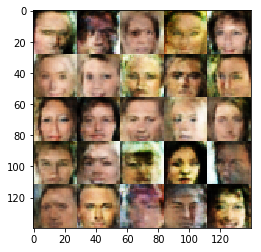

Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6472


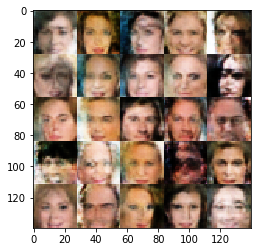

Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.7146
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.2686


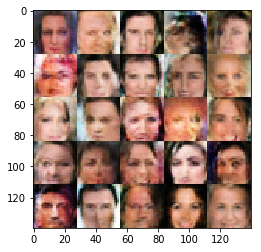

Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.5856
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.9995


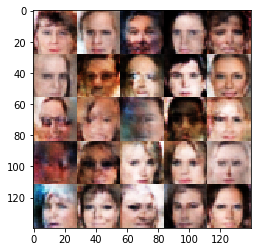

Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.5086
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.9384


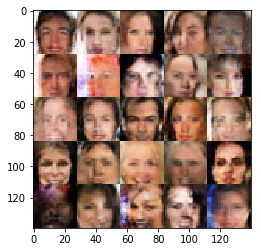

Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.4288
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 2.4307
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.4838


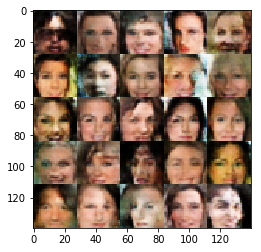

Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.4648
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.9960


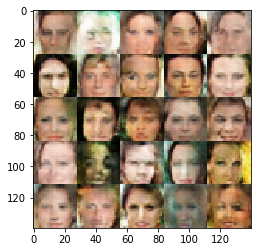

Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.2404


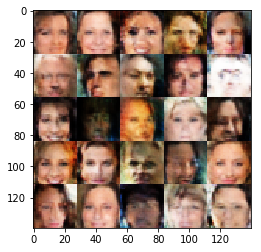

Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.0791


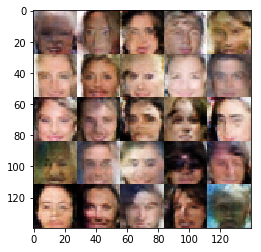

Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.9777


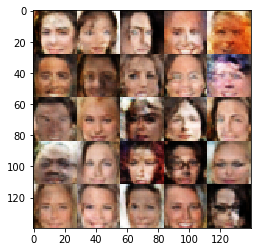

Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.5309


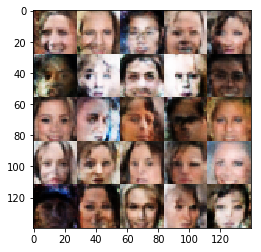

Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.7902
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.9447


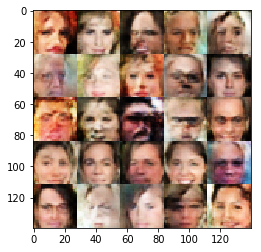

Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.9755


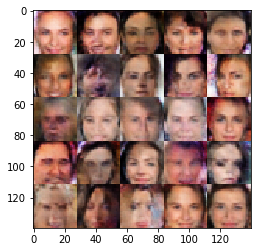

Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.2725


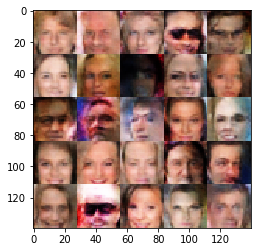

Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.7450


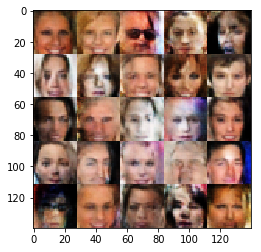

Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.3097


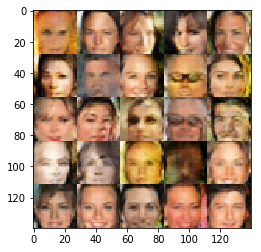

Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.6970


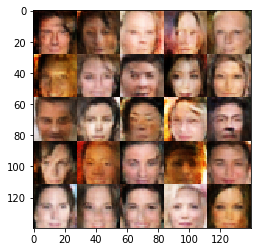

Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.5850
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.5117
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.7841


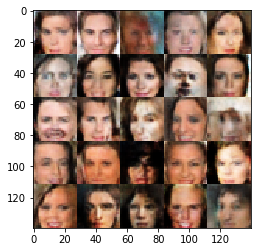

Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.7219


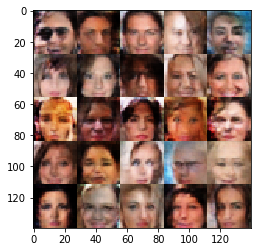

In [13]:
batch_size = 56
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.